# 簡易実装CBOWによる密ベクトルの学習例
## 前提
- [ゼロから作るDeep Learning ❷ ―自然言語処理編](https://github.com/oreilly-japan/deep-learning-from-scratch-2/)のクローンを用意。
- ch03に移動し、そこで作業。

In [1]:
import collections, os, pickle
import nltk, MeCab
import matplotlib.pyplot as plt

# データの準備
filename = "./corpus/momotaro.txt"
with open(filename, "r") as fh:
    sentences = ""
    for line in fh.readlines():
        sentences += line + " "

def tokenize(sentences):
    """文章を分かち書きするとともに、ボキャブラリも返す。

    :param sentences(str): 複数の文章を含む文字列。日本語想定。
    :return(list):
      tokens(list): 分かち書きした単語をlistとしてまとめたもの。
      vocab(list): ボキャブラリ。ユニークな単語一覧。
    """

    # 「。」、「！」、「？」で終わる一連の文字列を文として認識し分割する。
    jp_sent_tokenizer = nltk.RegexpTokenizer(u'[^　「」！？。]*[！？。]')
    tagger = MeCab.Tagger('-Owakati -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')

    sents = jp_sent_tokenizer.tokenize(sentences)
    tokens = []
    vocab = []
    for sent in sents:
        node = tagger.parseToNode(sent)
        while node:
            features = node.feature.split(",")
            base_word = features[6]
            if base_word == "*" or base_word == " " or base_word == "\n":
                node = node.next
                continue
            tokens.append(base_word)
            if base_word not in vocab:
                vocab.append(base_word)
            node = node.next
    return tokens, vocab

# 文章からボキャブラリと分かち書きを用意。
filename = "./corpus/momotaro.txt"
with open(filename, "r") as fh:
    sentences = ""
    for line in fh.readlines():
        sentences += line + " "
wakati_sentences, vocab = tokenize(sentences)

print("vocab[:5]", vocab[:5])
print("len(vocab)", len(vocab))


vocab[:5] ['むかし', '、', 'ある', 'ところ', 'に']
len(vocab) 551


In [2]:
# ボキャブラリと分かち書き文章から、データセットを作成。
word_to_id = dict((c,i) for i,c in enumerate(vocab))
id_to_word = dict((i,c) for i,c in enumerate(vocab))
print(word_to_id["桃太郎"])
print(id_to_word[178])


178
桃太郎


In [3]:
# 分かち書き文章を単語IDで表現
wakati_ids = []
for word in wakati_sentences:
    wakati_ids.append(word_to_id[word])

print(wakati_ids[:5])
print(id_to_word[0], id_to_word[1], id_to_word[0], id_to_word[1], id_to_word[2])

[0, 1, 0, 1, 2]
むかし 、 むかし 、 ある


In [4]:
#https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/ch03/train.py
#ここから CBOW 準備

import sys
sys.path.append('..')  # 親ディレクトリのファイルをインポートするための設定
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot, cos_similarity

window_size = 5
hidden_size = 20 # 密ベクトルのサイズ
batch_size = 100 # 一度に処理するサンプル数
max_epoch = 1000 # 重み更新回数（学習回数）

# データセットの準備
vocab_size = len(vocab)

# ウィンドウサイズで指定された文脈と、その文脈下における対象語を収集
contexts, target = create_contexts_target(wakati_ids, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

print(target[0])

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [5]:
# モデルの準備
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)


use pretrained file (word2vec_momotaro_model.pkl)? [y/n]
y


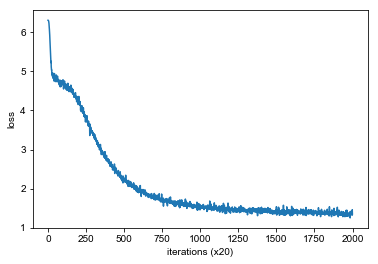

In [10]:
# 学習。必要に応じて学習済みファイルから読み込み。
model_filename = "word2vec_momotaro_model.pkl"
trainer_filename = "word2vec_momotaro_trainer.pkl"
answer = "n"
if os.path.exists(filename):
    print("use pretrained file ({})? [y/n]".format(model_filename))
    answer = input()
if answer == "n":
    trainer.fit(contexts, target, max_epoch, batch_size)
    trainer.plot()
    pickle.dump(model, open(model_filename, 'wb'))
    pickle.dump(trainer, open(trainer_filename, 'wb'))
elif answer == "y":
    model = pickle.load(open(model_filename, 'rb'))
    trainer = pickle.load(open(trainer_filename, 'rb'))
    trainer.plot()


In [7]:
# 学習した密ベクトルを利用しやすいように整形
embeddings = model.word_vecs
word_to_vec = dict()
for index, word in enumerate(vocab):
    vec = embeddings[index]
    word_to_vec[word] = vec


In [8]:
def closest(embeddings, word, n):
    """密ベクトル集合から、指定された単語に類似した単語を検索して出力する。

    :param embeddings: 単語の密ベクトルを辞書型で保存したもの。{word:vector}
    :param word: 検索対象語。str型。
    :param n: 類似度が最も高いn件まで出力。
    """
    distances = dict()
    for w in embeddings.keys():
        distances[w] = cos_similarity(embeddings[w],embeddings[word])
    d_sorted = collections.OrderedDict(sorted(distances.items(),key = lambda x:x[1] ,reverse = True))
    s_words = list(d_sorted.keys())
    print("closest({})".format(word))
    print(s_words[:n])

    # 参考用に3件まで類似度を出力
    print(cos_similarity(embeddings[word], embeddings[s_words[0]]), word, s_words[0])
    print(cos_similarity(embeddings[word], embeddings[s_words[1]]), word, s_words[1])
    print(cos_similarity(embeddings[word], embeddings[s_words[2]]), word, s_words[2])
    print("----")

closest(word_to_vec,'桃太郎',10)
closest(word_to_vec,'おじいさん',10)
closest(word_to_vec,'猿',10)
closest(word_to_vec,'鬼',10)


closest(桃太郎)
['桃太郎', 'こうして', 'ます', 'まいにち', 'ば', 'へ', '元気', 'ら', 'やる', '下さる']
1.0 桃太郎 桃太郎
0.63193345 桃太郎 こうして
0.6279346 桃太郎 ます
----
closest(おじいさん)
['おじいさん', '下りる', '気だて', '中', '早い', 'がた', 'うらら', '近所', 'みる', 'ちがい']
1.0000001 おじいさん おじいさん
0.56877404 おじいさん 下りる
0.55369145 おじいさん 気だて
----
closest(猿)
['猿', 'す', '向こう', 'ある', 'ずんずん', 'こそ', 'がる', '陸', 'え', '大きな']
0.99999994 猿 猿
0.7311974 猿 す
0.5919237 猿 向こう
----
closest(鬼)
['鬼', '犬', 'さんざん', 'そんな', 'おいで', '泣く', 'その', '押さえる', '見える', '稲妻']
1.0 鬼 鬼
0.65054655 鬼 犬
0.6279972 鬼 さんざん
----


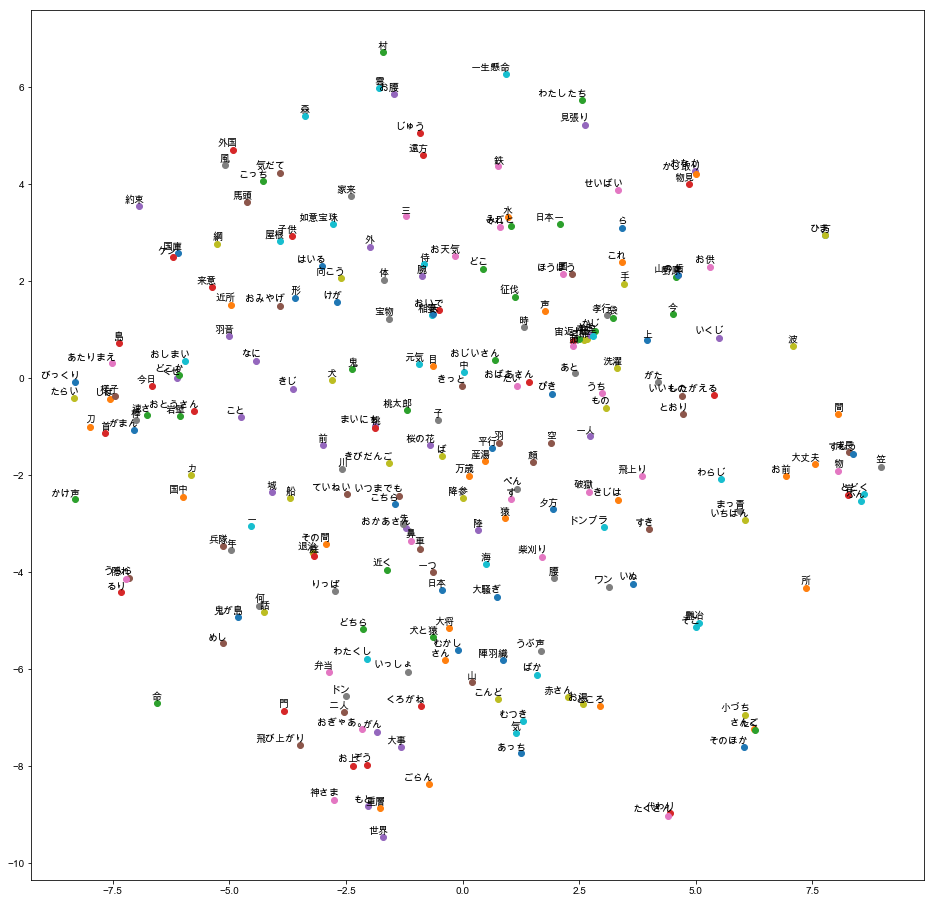

In [9]:
# t-SNE visualization
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
#上記エラーに対応するための環境変数設定。なお、エラー文全文によるとこの方法は非推奨の模様。
#nokmlをインストールすることで解決できるケースが多いようだけど、試した限りでは途中で関連ライブラリのインストールが止まるため、今回は環境変数設定で対応することに。
#参考：https://stackoverflow.com/questions/53648730/omp-error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-in

# フォント設定
import matplotlib
import matplotlib.font_manager as font_manager
font_path = '/Library/Fonts/Arial Unicode.ttf'
font_prop = font_manager.FontProperties(fname = font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()

# TSNE設定
from sklearn.manifold import TSNE
tagger = MeCab.Tagger('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')
labels = []
tokens = []
for w in word_to_vec.keys():
    # 全ての単語を描画したい場合、ここでの品詞判定をせずに、全てlabels.appendすると良い。
    temp = tagger.parse(w).split()[1]
    pos = temp.split(',')[0]
    if pos == '名詞':
        labels.append(w)
        tokens.append(word_to_vec[w])

# 各種パラメータは適宜ドキュメント参照。ここでは固定したいのでシード値も設定。
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16))
for i in range(len(x)):
    plt.scatter(x[i], y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()
